<a href="https://colab.research.google.com/github/dariRusAG/CBOW/blob/main/cbow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая реализация Word2Vec: CBOW

## Загрузка бибилиотек и файлов

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving source-text.txt to source-text.txt


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200
%matplotlib inline

from nltk import sent_tokenize, word_tokenize
from string import punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Предообработка текста

In [ ]:
with open("Anna-Karenina.txt", "r", encoding="utf-8") as file:
  text = file.read()

# Токенизация текста
text = sent_tokenize(text, language='russian')
words_text = []

for sent in text:
  sent = word_tokenize(sent, language='russian') 
  words_text.append(sent)

print('Количество предложений:', len(words_text))
print('Пример предложения:', words_text[12])

Количество предложений: 19874
Пример предложения: ['Алабин', 'давал', 'обед', 'в', 'Дармштадте', ';', 'нет', ',', 'не', 'в', 'Дармштадте', ',', 'а', 'что-то', 'американское', '.']


In [ ]:
# Обработка массива токенизированного текста
stop_words = nltk.corpus.stopwords.words('russian')
remove_terms = punctuation + '0123456789' + str(stop_words) + 'XVI'

# Приведение в нижний регистр и удаление знаков препинаний, цифр и стоп-слов
norm_words_text = [[word.lower() for word in sent if word not in remove_terms] for sent in words_text]

# Удаление лишних пробелов в словах
norm_words_text = [' '.join(tok_sent) for tok_sent in norm_words_text]

# Фильтрация пустых значений
norm_words_text = filter(None, norm_words_text)

# Оставляет предложения, длина которых больше двух слов
norm_words_text = [tok_sent for tok_sent in norm_words_text if len(tok_sent.split()) > 2]

print('Пример обработанного предложения:', norm_words_text[9])

Пример обработанного предложения: алабин давал обед дармштадте дармштадте что-то американское


## Реализация модели непрерывного мешка слов (CBOW)
Мы будем использовать корпус произведения Льва Толстова, содержащийся в norm_words_text переменной, для обучения нашей модели. 

Реализация будет состоять из пяти частей:
- Формирование корпусной лексики.
- Создание генератора CBOW (контекст, цель)
- Создание архитектуры модели CBOW
- Обучение модели
- Получение вложения слов

### Формирование корпусной лексики

In [ ]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.utils import pad_sequences

# Класс для векторизации текстового корпуса
tokenizer = text.Tokenizer()

# Создание словаря на основе списка предложений
tokenizer.fit_on_texts(norm_words_text)
# Указываем для возможной замены слов вне словаря
word2id = tokenizer.word_index
word2id['PAD'] = 0

# Запись словаря для каждого слова
id2word = {v:k for k, v in word2id.items()}
# Запись массива индексов слов по предложениям
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_words_text]

vocab_size = len(word2id)
# Параметр размера встраивания
embed_size = 100
# Параметр размера окна
window_size = 2

print('Размер словаря:', vocab_size)
print('Пример отрезка записей:', list(word2id.items())[12:18])

Размер словаря: 33581
Пример отрезка записей: [('кити', 13), ('что', 14), ('да', 15), ('очень', 16), ('вронский', 17), ('анна', 18)]


### Создание генератора CBOW

In [ ]:
# Функция создания окружающего контекста
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [ ]:
# Проверка работы функции на некоторых образцах
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Контекст (X):', [id2word[w] for w in x[0]], '-> Целевое слово (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Контекст (X): ['часть', 'первая', 'счастливые', 'семьи'] -> Целевое слово (Y): все
Контекст (X): ['первая', 'все', 'семьи', 'похожи'] -> Целевое слово (Y): счастливые
Контекст (X): ['все', 'счастливые', 'похожи', 'друга'] -> Целевое слово (Y): семьи
Контекст (X): ['счастливые', 'семьи', 'друга', 'каждая'] -> Целевое слово (Y): похожи
Контекст (X): ['семьи', 'похожи', 'каждая', 'несчастливая'] -> Целевое слово (Y): друга
Контекст (X): ['похожи', 'друга', 'несчастливая', 'семья'] -> Целевое слово (Y): каждая
Контекст (X): ['друга', 'каждая', 'семья', 'несчастлива'] -> Целевое слово (Y): несчастливая
Контекст (X): ['каждая', 'несчастливая', 'несчастлива', 'по'] -> Целевое слово (Y): семья
Контекст (X): ['несчастливая', 'семья', 'по', 'своему'] -> Целевое слово (Y): несчастлива
Контекст (X): ['жена', 'узнала', 'связи', 'бывшею'] -> Целевое слово (Y): муж
Контекст (X): ['узнала', 'муж', 'бывшею', 'доме'] -> Целевое слово (Y): связи


### Создание архитектуры модели CBOW

#### Сводная информация о модели CBOW

In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# Предоставляет функции обучения и вывода на модели
cbow = Sequential()
# Превращает индексы в плотные векторы фиксированного размера
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
# Позволяет использовать произвольные выражения можно как Layer (слои)
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
# Плотно связанный слой NN
cbow.add(Dense(vocab_size, activation='softmax'))

# Настройка модели для обучения (задаем функцию потерь и связываем с оптимизатором)
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4, 100)            3358100   
                                                                 
 lambda_1 (Lambda)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 33581)             3391681   
                                                                 
Total params: 6,749,781
Trainable params: 6,749,781
Non-trainable params: 0
_________________________________________________________________
None


#### Архитектура модели CBOW

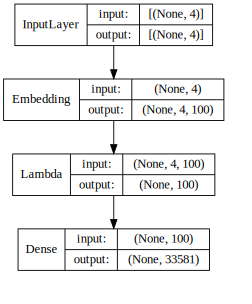

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, 
                 show_shapes=True, 
                 show_layer_names=False, 
                 rankdir='TB', 
                 dpi=65).create(prog='dot', format='svg'))

### Обучение модели

In [ ]:
for epoch in range(1, 3):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        # Выполняет обновление одного градиента на одном пакете данных
        loss += cbow.train_on_batch(x, y)
        if i % 50000 == 0:
            print('Обработанные {} (контекст, слово) пары'.format(i))

    print('Эпоха:', epoch, '\tПотеря:', loss)
    print()

cbow.save('cbow_model')

Обработанные 50000 (контекст, слово) пары
Обработанные 100000 (контекст, слово) пары
Обработанные 150000 (контекст, слово) пары
Эпоха: 1 	Потеря: 1968591.2934104921

Обработанные 50000 (контекст, слово) пары
Обработанные 100000 (контекст, слово) пары
Обработанные 150000 (контекст, слово) пары
Эпоха: 2 	Потеря: 2610018.6992012667



### Получение вложения слов

In [ ]:
# Выведем текущие веса слоя в виде массива
weights = cbow.get_weights()[0]
weights = weights[1:]

# Форма массива
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(33580, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
сказал,0.990152,0.184432,0.241939,-0.177543,0.590066,-0.072413,-0.563876,0.126168,-0.136399,-0.256524,...,-1.070905,-0.252562,-0.077355,-0.904248,-0.225602,-0.918204,-0.336243,0.297475,0.623323,-0.237133
левин,0.399935,0.045563,-0.116099,0.064489,0.193756,-0.223457,-0.172362,-0.034815,0.448570,-0.051392,...,-0.008398,-0.169628,-0.334526,-0.029819,-0.325852,-0.106908,0.172825,0.393168,0.168063,0.005490
я,0.264774,-0.113480,-0.306756,-0.050578,-0.132539,-0.318793,-0.351446,-0.365510,0.028509,0.075073,...,0.330151,-0.094996,0.087466,0.186258,-0.387014,-0.533224,0.205223,0.399171,-0.351990,-0.100584
он,0.115210,0.151952,-0.039631,-0.226000,0.047860,-0.038817,-0.119592,-0.144707,0.071382,-0.199208,...,0.147206,-0.047145,0.087838,0.024730,0.102143,-0.182528,0.212086,0.337269,-0.299803,0.186486
и,0.143073,-0.107476,-0.115367,-0.226757,0.002305,-0.213755,-0.180644,-0.206927,0.122819,0.118938,...,0.136066,-0.335896,0.144660,-0.120741,-0.010096,-0.317939,0.118021,0.277143,-0.098968,-0.029536


#### Строим матрицу попарных расстояний среди всех слов в нашем словаре

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# Вычисление попарной матрицы расстояний
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# Вывод контекстно-подобных слов
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['анна', 'семья', 'жена', 'любовь', 'муж']}

similar_words

(33580, 33580)


{'анна': ['долли', 'мужа', 'дома', 'вронского', 'нему'],
 'семья': ['каблуками', 'политической', 'недостатков', 'стоявших', 'убить'],
 'жена': ['этими', 'большой', 'ожидая', 'сторон', 'самыми'],
 'любовь': ['любви', 'выражением', 'вместо', 'руках', 'сестры'],
 'муж': ['таким', 'границей', 'второй', 'права', 'неприятно']}

#### Визуализируем вложения слов, используя t-SNE 

Общее количество групп слов: 30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


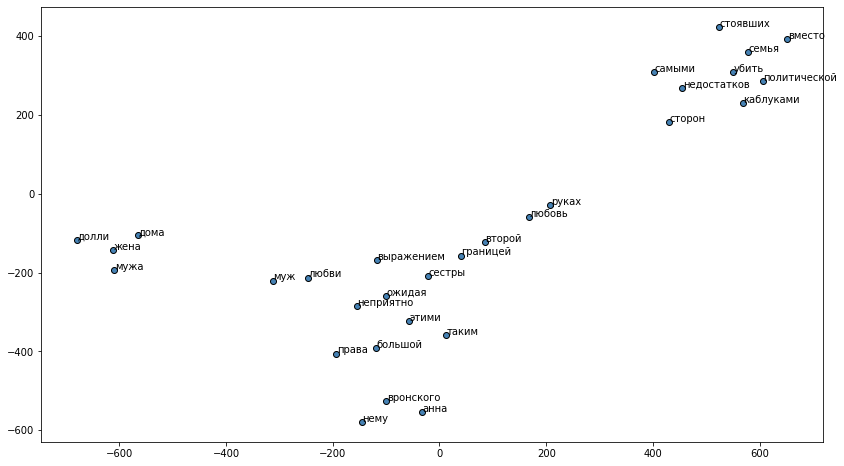

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Общее количество групп слов:', len(words))

# Стохастическое вложение соседей с t-распределением
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
# Определим способ отображения чисел с плавающей запятой
np.set_printoptions(suppress=True)
# Стандартизируем функции, удалив среднее значение и масштабируя до единичной дисперсии
T = tsne.fit_transform(word_vectors)

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(words, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Word2Vec с Gensim
В нашем рабочем процессе мы будем токенизировать наш нормализованный корпус.

In [ ]:
from gensim.models import word2vec

# Токенизация предложений в корпусе
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_words_text]

# Установка значений для различных параметров

feature_size = 100   # Размерность вектора слова  
window_context = 30  # Размер контекстного окна                                                                                    
min_word_count = 1   # Минимальное количество слов                        
sample = 1e-3        # Настройка понижения частоты для частых слов
number_epoch = 50    # Количество эпох (перебор корпуса)

w2v_model = word2vec.Word2Vec(tokenized_corpus, 
                              size=feature_size, 
                              window=window_context, 
                              min_count=min_word_count,
                              sample=sample, 
                              iter=number_epoch, 
                              cb = 0)

# Вывод похожих слова на основе модели gensim
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['анна', 'семья', 'жена', 'любовь', 'муж']}
similar_words

{'анна': ['долли', 'она', 'анну', 'щербацкого', 'мужа'],
 'семья': ['воспитанные', 'вырастут', 'наклонностями', 'грубыми', 'зверскими'],
 'жена': ['избегала', 'бетси', 'настаивала', 'косо', 'царское'],
 'любовь': ['страсть', 'любви', 'связывавшая', 'любила', 'обманывать'],
 'муж': ['определится', 'считает', 'комическою', 'поедет', 'обманутый']}

### Визуализируем группы вложений слов, используя t-SNE

Общее количество групп слов: 30


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


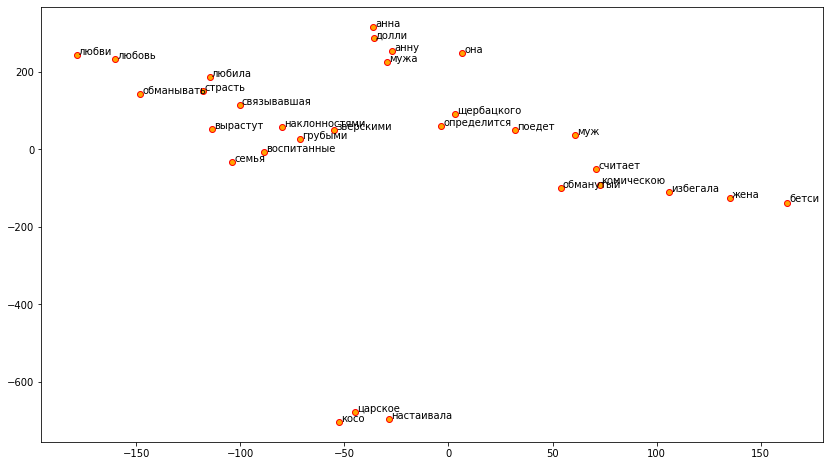

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
print('Общее количество групп слов:', len(words))
wvs = w2v_model.wv[words]

# Стохастическое вложение соседей с t-распределением
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
# Определим способ отображения чисел с плавающей запятой
np.set_printoptions(suppress=True)
# Стандартизируем функции, удалив среднее значение и масштабируя до единичной дисперсии
T = tsne.fit_transform(wvs)

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(words, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Применение функций Word2Vec для задач обработки естественного языка: автореферирование

### Инициализация исходного текста

In [ ]:
with open("source-text.txt", "r", encoding="utf-8") as file:
  text = file.read()

text = sent_tokenize(text, language='russian')
corpus = np.array(text)

###  Обработка исходного текста

In [ ]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('russian')

def normalize_document(doc):
    doc = re.sub(r'[^а-яА-Я]', ' ', doc)
    doc = doc.lower()
    doc = doc.strip()
    tokens = wpt.tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

# Определим векторизованную функцию
normalize_corpus = np.vectorize(normalize_document)

### Вывод кортежа массивов

In [ ]:
norm_corpus = normalize_corpus(corpus) 
norm_corpus

array(['ясны циркуляры газетные статьи которых запрещалось',
       'циркуляре запрещалось ученикам выходить улицу девяти часов вечера статье запрещалась плотская любовь это ясно определенно запрещено баста',
       'разрешении позволении скрывался элемент сомнительный недосказанное смутное',
       'городе разрешали драматический кружок читальню чайную покачивал головой говорил тихо оно вс это прекрасно вышло',
       'всякого рода нарушения уклонения отступления правил приводили уныние хотя казалось какое дело',
       'товарищей опаздывал молебен доходили слухи проказе гимназистов видели классную даму поздно вечером офицером очень волновался вс говорил вышло',
       'педагогических советах просто угнетал своею осторожностью мнительностью своими чисто футлярными соображениями насчет де мужской женской гимназиях молодежь ведет дурно очень шумит классах ах дошло начальства ах вышло б второго класса исключить петрова четвертого егорова очень',
       'своими вздохами нытьем своими темн

### Подключение обученной модели

In [ ]:
from gensim.models import Word2Vec
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Установка значений для различных параметров
feature_size = 10    # Размерность вектора слова 
window_context = 10  # Размер контекстного окна                                                                                    
min_word_count = 1   # Минимальное количество слов                        
sample = 1e-3        # Настройка понижения частоты для частых слов

w2v_model = Word2Vec(tokenized_corpus, 
                     size=feature_size, 
                     window=window_context, 
                     min_count = min_word_count,
                     sample=sample, 
                     iter=100, 
                     sg=0)

In [ ]:
# from keras.models import load_model
# loaded_model = load_model('cbow_model')

### Визуализация вложений

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


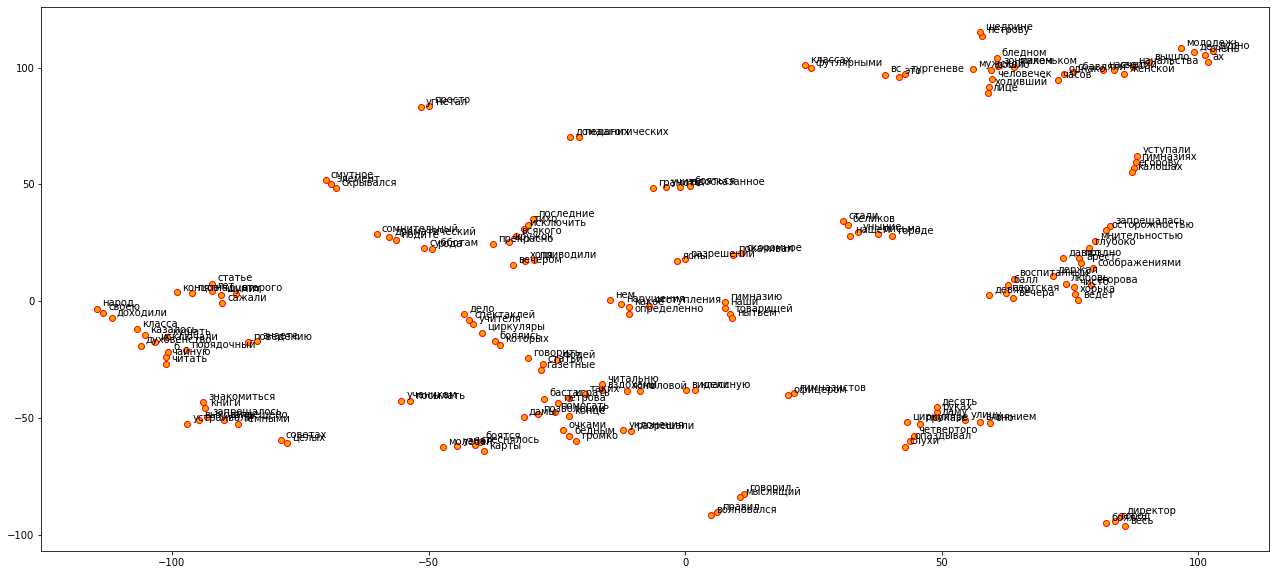

In [ ]:
from sklearn.manifold import TSNE
words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(22, 10))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Векторизация предложений

In [ ]:
# Функция векторизатора слов
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
# Функция векторизатора предложений
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

# Получить вложения для каждого предложения
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, 
                                             model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9
0,-0.007612,0.006995,0.003707,0.020907,0.018687,0.074099,-0.050330,-0.109492,-0.064250,-0.036440
1,0.009422,-0.044743,0.038006,0.036838,0.031048,0.165389,-0.088645,-0.172205,-0.133003,-0.066932
2,0.036836,-0.050470,0.008024,0.000983,0.012235,0.067220,-0.023105,-0.105013,-0.060052,-0.028037
3,0.017962,-0.057404,0.017734,0.030649,0.037456,0.135311,-0.077704,-0.185315,-0.108242,-0.050228
4,0.007377,-0.041667,0.005069,0.020856,0.039525,0.140332,-0.041391,-0.136314,-0.092909,-0.067693
5,0.007358,-0.067379,0.011249,0.022603,0.054186,0.141469,-0.080002,-0.209486,-0.122791,-0.070239
6,0.016796,-0.076907,0.025385,0.038385,0.063836,0.198467,-0.087607,-0.244783,-0.159251,-0.092914
7,-0.008779,-0.068871,0.042624,0.034619,0.044725,0.188553,-0.079154,-0.226029,-0.138970,-0.074883
8,-0.001164,0.012097,-0.000755,0.026011,0.048748,0.092135,-0.055251,-0.128523,-0.040621,-0.088216
9,0.001806,0.007894,0.029498,0.003739,-0.044711,-0.017858,0.036124,-0.035977,-0.012647,-0.020284


### Группировка предложений

In [ ]:
from sklearn.cluster import AffinityPropagation

print('Кластеры, назначенные на основе характеристик нашего документа\n')

corpus_df = pd.DataFrame({'Предложение': corpus})

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_

cluster_labels = pd.DataFrame(cluster_labels, columns=['Категория'])
pd.concat([corpus_df, cluster_labels], axis=1)

Кластеры, назначенные на основе характеристик нашего документа

10


### Визуализация расположения каждого предложения в каждом кластере

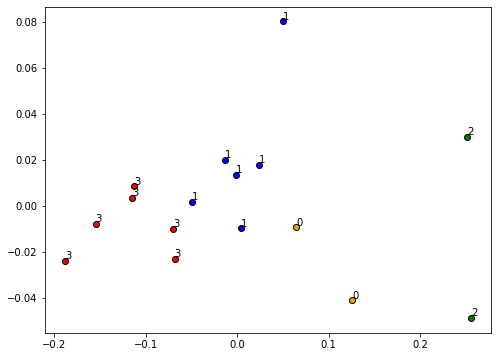

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
cluster_labels = pd.DataFrame(labels, columns=['Категория'])
categories = list(cluster_labels['Категория'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green' if label == 2 else 'red'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

### Создание матрицы подобия косинусов

In [ ]:
n = 10
from sklearn.metrics.pairwise import cosine_similarity

sim_mat = np.zeros([len(w2v_feature_array), len(w2v_feature_array)])
for i in range(len(w2v_feature_array)):
      for j in range(len(w2v_feature_array)):
        if i != j:
              sim_mat[i][j] = cosine_similarity(w2v_feature_array[i].reshape(1, n), 
                                                w2v_feature_array[j].reshape(1, n))[0][0]

norm = np.sum(sim_mat, axis=1)
sim_mat = np.divide(sim_mat, norm, where=norm!=0)
pd.DataFrame(sim_mat)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.074900,0.069551,0.074114,0.073878,0.073963,0.073675,0.074033,0.078639,0.061565,0.072854,0.071943,0.066433,0.074340,0.073920,0.076680
1,0.076364,0.000000,0.074296,0.076176,0.076570,0.075465,0.076060,0.076471,0.074853,0.049197,0.075931,0.078309,0.052833,0.074577,0.077311,0.077330
2,0.069027,0.072322,0.000000,0.074251,0.073199,0.073861,0.073550,0.072671,0.067780,0.088985,0.074743,0.081463,0.064507,0.072057,0.074219,0.071562
3,0.076139,0.076756,0.076858,0.000000,0.076293,0.076749,0.076485,0.076476,0.074975,0.048385,0.076842,0.079536,0.057754,0.075058,0.077473,0.077096
4,0.075030,0.076273,0.074905,0.075423,0.000000,0.075533,0.076211,0.076021,0.076541,0.038335,0.075828,0.077916,0.051007,0.075890,0.076428,0.075957
5,0.076084,0.076140,0.076555,0.076851,0.076506,0.000000,0.076536,0.076362,0.075968,0.047034,0.076701,0.079058,0.068703,0.075561,0.076716,0.076098
6,0.076010,0.076965,0.076457,0.076810,0.077418,0.076760,0.000000,0.076769,0.076033,0.050648,0.076892,0.079055,0.063950,0.076035,0.077299,0.076620
7,0.076075,0.077072,0.075242,0.076496,0.076917,0.076281,0.076463,0.000000,0.075139,0.064369,0.076294,0.076779,0.064634,0.075483,0.076777,0.076951
8,0.075163,0.070172,0.065275,0.069756,0.072034,0.070586,0.070440,0.069891,0.000000,0.036243,0.069666,0.064468,0.080122,0.073894,0.070176,0.073601
9,0.010608,0.008314,0.015448,0.008115,0.006504,0.007878,0.008459,0.010793,0.006533,0.000000,0.007971,-0.000557,0.180551,0.012359,0.005276,0.008257


### Расчет баллов Pagerank для каждого предложения

In [ ]:
import networkx as nx

G = nx.from_numpy_array(np.array(sim_mat))  
scores = nx.pagerank(G)

# Вывод лучших k-предложений с наивысшими баллами
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(text)), reverse=True)

k = int(len(text) / 10 + 0.5)
my_list = []
for i in range(k):
    my_list.append(ranked_sentences[i][1])

for i in text:
  if i in my_list:
    print(i + '\n') 

Вот подите же, наши учителя народ всё мыслящий, глубоко порядочный, воспитанный на Тургеневе и Щедрине, однако же этот человечек, ходивший всегда в калошах и с зонтиком, держал в руках всю гимназию целых пятнадцать лет!

Наши дамы по субботам домашних спектаклей не устраивали, боялись, как бы он не узнал; и духовенство стеснялось при нем кушать скоромное и играть в карты.

Под влиянием таких людей, как Беликов, за последние десять — пятнадцать лет в нашем городе стали бояться всего.

Боятся громко говорить, посылать письма, знакомиться, читать книги, боятся помогать бедным, учить грамоте…

